# Wikidata information

In [1]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
from matplotlib.font_manager import fontManager
from collections import Counter

path = "../datasets.jsonl"
font_path = "../TaipeiSansTCBeta-Regular.ttf"

fontManager.addfont(font_path)
mpl.rc('font', family='Taipei Sans TC Beta')

o_dataset = []
with open(path, "r") as f: #游標位置會變
    line_count = 0
    for line in f:
      line_count += 1
    f.seek(0) #讓游標讀取位置回到原點
    for i in range(line_count):
        line = f.readline()
        data = json.loads(line)
        o_dataset.append(data)
print(o_dataset[:2])


[{'author': 'Mark Z', 'author_email': None, 'contact_email': '', 'contact_person': '', 'creator_user_id': '0e60f4fd-46f2-4d45-8f1c-5370483e59bb', 'data_type': ['code'], 'groups': [], 'id': '92ddf266-9c77-4963-a291-24707cbaf8ba', 'isopen': False, 'keywords': [], 'language': [], 'license_id': 'notspecified', 'license_title': 'License Not Specified', 'maintainer': None, 'maintainer_email': None, 'metadata_created': '2023-08-12T06:54:37.170871', 'metadata_modified': '2023-08-12T07:03:40.197025', 'name': 'markz-s', 'notes': '', 'num_resources': 1, 'num_tags': 0, 'organization': None, 'private': False, 'process_step': '', 'relationships_as_object': [], 'relationships_as_subject': [], 'remarks': '', 'resources': [{'cache_last_updated': None, 'cache_url': None, 'created': '2023-08-12T07:03:28.447456', 'datastore_active': False, 'datastore_contains_all_records_of_source_file': False, 'description': '', 'format': 'HTML', 'hash': '', 'id': '66dac949-2b2a-40dd-afda-6292fc41df98', 'last_modified': 

## wikidata keywords

[{51, 'Taijiang Inner Sea'}, {49, 'Changhua County Government'}, {48, 'drainage system'}, {'Taiwan', 46}, {'unmanned aerial vehicle', 46}, {34, 'Forward-looking foundation construction plans in Taiwan'}, {'Tainan', 31}, {'Web Map Tile Service', 31}, {27, 'thesis'}, {24, 'historical atlas'}]


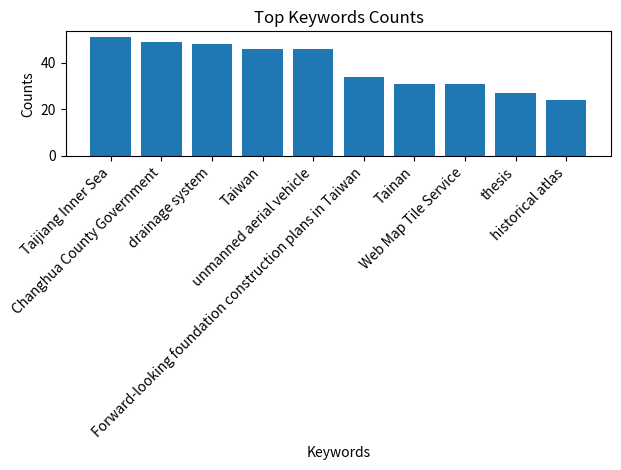

In [2]:
keywords = []

for i in o_dataset:
  if i.get('keywords') is not None:
    for j in i['keywords']:
      keywords.append(j)
keywords_count = Counter(keywords)
mostuse_key = keywords_count.most_common(10)

key_name = [i[0] for i in mostuse_key]
key_value = [i[1] for i in mostuse_key]

def find_word(list1):
  word_list = []
  for i in list1:
    endpoint_url = f"https://www.wikidata.org/wiki/Special:EntityData/{i}.json"
    response = requests.get(endpoint_url)
    if response.status_code == 200:
        data = response.json()
        # The label (name) of the entity will be available in the 'labels' section of the JSON response
        label = data['entities'][i]['labels']['en']['value']
        word_list.append(label)
    else:
        print("Error occurred:", response.text)
  return word_list

word_list = find_word(key_name)
key_value = [i[1] for i in mostuse_key]
wikidata = []
for i in range(len(word_list)):
  wikidata.append({word_list[i],key_value[i]})
print(wikidata)

plt.bar(word_list,key_value)
plt.xlabel('Keywords')
plt.ylabel('Counts')
plt.title('Top Keywords Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 搜尋tag中是wikidata關鍵字

比較最常用的tag 是否有在wikidata中出現

In [3]:
from wikidataintegrator import wdi_core


def is_tag_in_wikidata(tag):
    sparql_query = []
    if type_word(tag[0])=="En":
      sparql_query = f'SELECT ?item WHERE {{ ?item rdfs:label "{tag}"@en }}'
    elif type_word(tag[0])=="CH":
      sparql_query = f'SELECT ?item WHERE {{ ?item rdfs:label "{tag}"@zh. }}'
    else:
      sparql_query = f'''
          SELECT ?item WHERE {{
              {{ ?item rdfs:label "{tag}"@en. }}
              UNION
              {{ ?item rdfs:label "{tag}"@zh-TW. }} }} '''

    result = wdi_core.WDItemEngine.execute_sparql_query(sparql_query) #executes the SPARQL query

    if result['results']['bindings']:
        return True
    else:
        return False

def type_word(word):

    ascii_code = ord(word)
    if (65 <= ascii_code <= 90 or 97 <= ascii_code <= 122):
        return "En"
    elif (48 <= ascii_code <= 57):
      return "num"
    return "CH"
url = "http://data.depositar.io/api/3/action/package_search?facet.field=[%22tags%22]&facet.limit=10"
package_list = requests.get(url).json()

tag_number =  package_list['result']['facets']['tags']
tag_list = list(tag_number.items())
tag_list_keys  = list(tag_number.keys())
filter_tags = [tag for tag in tag_number if is_tag_in_wikidata(tag)]


def compare(list1,list2):
  set1 = set(list1)
  set2 = set(list2)

  common_set = set1.intersection(set2)
  diff_set = set1.difference(set2)

  return common_set,diff_set

intersect,differ = compare(tag_list_keys,filter_tags)
print("重複出現",intersect)
print("需要補充",differ)

重複出現 {'台江國家公園', '高雄市', 'UAV', 'UAS', '論文'}
需要補充 {'playaround workshop', '前瞻水環境建設', '生態檢核', 'LTSER', '水與安全計畫'}
